<a href="https://colab.research.google.com/github/thomas-c-reid/TensorflowDeepLearning/blob/master/14_Text_prediction_using_LSTM.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [17]:
from keras.models import Sequential
from keras.layers import Dense, Dropout, LSTM
from keras.optimizers import RMSprop
import numpy as np
import random
import sys

**Importing data and formatting**

In [18]:
filename = "JungleBook.txt"
raw_text = open(filename, 'r', encoding='utf-8').read().lower()
print(len(raw_text))


raw_text = "".join(C for C in raw_text if not C.isdigit())

chars = sorted(list(set(raw_text)))
print(chars)

char_to_int = dict((c, i) for i,c in enumerate(chars))
int_to_char = dict((i, c) for i,c in enumerate(chars))

n_chars = len(raw_text)
n_vocab = len(chars)
print("Total Characters in the text; corpus length: ", n_chars)
print("Total Vocab: ", n_vocab)

293051
['\n', ' ', '!', '#', '$', '%', '(', ')', '*', ',', '-', '.', '/', ':', ';', '?', '@', '[', ']', '`', 'a', 'b', 'c', 'd', 'e', 'f', 'g', 'h', 'i', 'j', 'k', 'l', 'm', 'n', 'o', 'p', 'q', 'r', 's', 't', 'u', 'v', 'w', 'x', 'y', 'z', '‘', '’', '“', '”', '\ufeff']
Total Characters in the text; corpus length:  292870
Total Vocab:  51


In [19]:
seq_length = 60
step = 10
sentences = []
next_chars = []
for i in range(0, n_chars - seq_length, step):  
    sentences.append(raw_text[i: i + seq_length])  #Sequence in
    next_chars.append(raw_text[i + seq_length])  #Sequence out
n_patterns = len(sentences)    
print('Number of sequences:', n_patterns)


Number of sequences: 29281


In [20]:
x = np.zeros((len(sentences), seq_length, n_vocab), dtype=bool)
y = np.zeros((len(sentences), n_vocab), dtype=bool)
for i, sentence in enumerate(sentences):
    for t, char in enumerate(sentence):
        x[i, t, char_to_int[char]] = 1
    y[i, char_to_int[next_chars[i]]] = 1
    
print(x.shape)
print(y.shape)

(29281, 60, 51)
(29281, 51)


**Building the model**

In [27]:
simpleModel = Sequential()
simpleModel.add(LSTM(128, input_shape=(seq_length, n_vocab)))
simpleModel.add(Dense(n_vocab, activation="softmax"))

optimizer = RMSprop(learning_rate=0.01)
simpleModel.compile(loss="categorical_crossentropy", optimizer=optimizer)
simpleModel.summary()


Model: "sequential_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm_2 (LSTM)               (None, 128)               92160     
                                                                 
 dense_2 (Dense)             (None, 51)                6579      
                                                                 
Total params: 98,739
Trainable params: 98,739
Non-trainable params: 0
_________________________________________________________________


In [28]:
deepModel = Sequential()
deepModel.add(LSTM(128, return_sequences=True, input_shape=(seq_length, n_vocab)))
deepModel.add(Dropout(0.2))
deepModel.add(LSTM(128))
deepModel.add(Dropout(0.2))
deepModel.add(Dense(n_vocab, activation="softmax"))

deepModel.compile(loss="categorical_crossentropy", optimizer=optimizer)
deepModel.summary()


Model: "sequential_3"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm_3 (LSTM)               (None, 60, 128)           92160     
                                                                 
 dropout (Dropout)           (None, 60, 128)           0         
                                                                 
 lstm_4 (LSTM)               (None, 128)               131584    
                                                                 
 dropout_1 (Dropout)         (None, 128)               0         
                                                                 
 dense_3 (Dense)             (None, 51)                6579      
                                                                 
Total params: 230,323
Trainable params: 230,323
Non-trainable params: 0
_________________________________________________________________


In [30]:
from keras.callbacks import ModelCheckpoint

filepath="saved_weights/saved_weights-{epoch:02d}-{loss:.4f}.hdf5"
checkpointH1 = ModelCheckpoint(filepath, monitor='loss', verbose=1, save_best_only=True, mode='min')
checkpointH2 = ModelCheckpoint(filepath, monitor='loss', verbose=1, save_best_only=True, mode='min')

callbacks_listH1 = [checkpointH1]
callbacks_listH2 = [checkpointH2]


# Fit the model

history1 = simpleModel.fit(x, y,
          batch_size=128,
          epochs=50,   
          callbacks=callbacks_listH1)

history2 = deepModel.fit(x, y, 
          batch_size=128, 
          epochs=50, 
          callbacks=callbacks_listH2)

simpleModel.save("simpleJungleBookTextPrediction-LSTM-50epochs.h5")
deepModel.save("JungleBookTextPrediction-layered LSTN-50epochs.h5")




Epoch 1/50
229/229 [==============================] - ETA: 0s - loss: 0.6152
Epoch 1: loss improved from inf to 0.61522, saving model to saved_weights/saved_weights-01-0.6152.hdf5
229/229 [==============================] - 73s 319ms/step - loss: 0.6152
Epoch 2/50
229/229 [==============================] - ETA: 0s - loss: 0.6135
Epoch 2: loss improved from 0.61522 to 0.61355, saving model to saved_weights/saved_weights-02-0.6135.hdf5
229/229 [==============================] - 79s 345ms/step - loss: 0.6135
Epoch 3/50
229/229 [==============================] - ETA: 0s - loss: 0.6027
Epoch 3: loss improved from 0.61355 to 0.60273, saving model to saved_weights/saved_weights-03-0.6027.hdf5
229/229 [==============================] - 75s 329ms/step - loss: 0.6027
Epoch 4/50
229/229 [==============================] - ETA: 0s - loss: 0.5901
Epoch 4: loss improved from 0.60273 to 0.59010, saving model to saved_weights/saved_weights-04-0.5901.hdf5
229/229 [==============================] - 82s 36

**Testing Model**

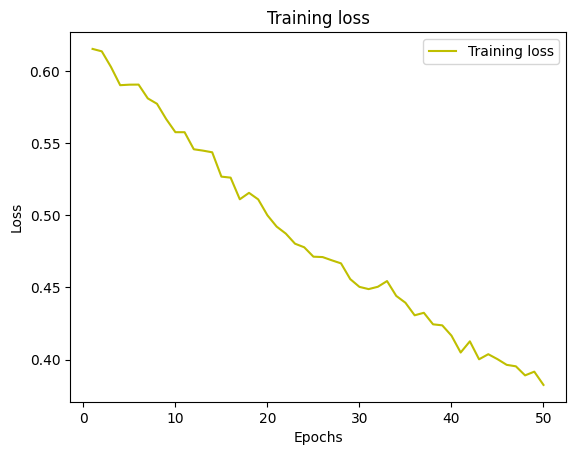

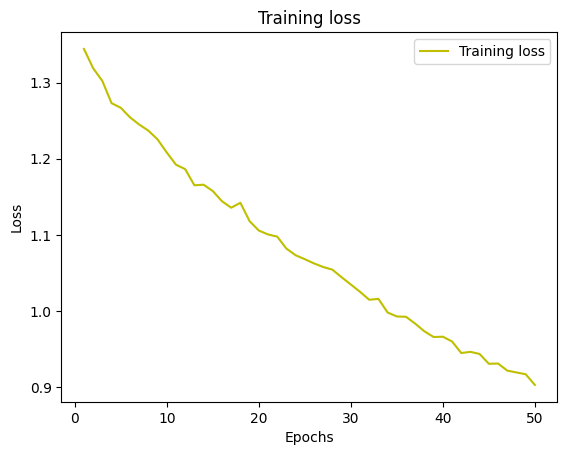

In [32]:
from matplotlib import pyplot as plt
#plot the training and validation accuracy and loss at each epoch
loss = history1.history['loss']
epochs = range(1, len(loss) + 1)
plt.plot(epochs, loss, 'y', label='Training loss')
plt.title('Training loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.show()

loss = history2.history['loss']
epochs = range(1, len(loss) + 1)
plt.plot(epochs, loss, 'y', label='Training loss')
plt.title('Training loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.show()

In [33]:
def sample(preds):
    preds = np.asarray(preds).astype('float64')
    preds = np.log(preds)
    exp_preds = np.exp(preds) #exp of log (x), isn't this same as x??
    preds = exp_preds / np.sum(exp_preds)
    probas = np.random.multinomial(1, preds, 1) 
    return np.argmax(probas)

In [34]:
filename = "JungleBookTextPrediction-layered LSTN-50epochs.h5"
deepModel.load_weights(filename)

#Pick a random sentence from the text as seed.
start_index = random.randint(0, n_chars - seq_length - 1)

#Initiate generated text and keep adding new predictions and print them out
generated = ''
sentence = raw_text[start_index: start_index + seq_length]
generated += sentence

print('----- Seed for our text prediction: "' + sentence + '"')

----- Seed for our text prediction: " his trumpet.

“stop that!” said billy and the troop horse t"


In [35]:
for i in range(400):   # Number of characters including spaces
    x_pred = np.zeros((1, seq_length, n_vocab))
    for t, char in enumerate(sentence):
        x_pred[0, t, char_to_int[char]] = 1.

    preds = simpleModel.predict(x_pred, verbose=0)[0]
    next_index = sample(preds)
    next_char = int_to_char[next_index]

    generated += next_char
    sentence = sentence[1:] + next_char

    sys.stdout.write(next_char)
    sys.stdout.flush()
print()

ime and the merow his dry not to the tore to be strange me sahcle into kill,
        les not

him, “he has crming, liveliceved without the councal in the fullow says up into kill, higr you
can’s leg fellow scortione of the stcrother and gruntl men the conornesing him too till leter as the sey saador tike

yould showly sick and just usching in the serle to the torain and littlight at was thust at d
